## Group 5 - Final Project - Pneumonia Image Diagnosis
### 489489 Xingchen Li
### 490489 Fengqiao Yang
### 491859 Shijie Liu

## Read files names into a dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import pandas as pd
import os
for i,j,k in os.walk('/content/drive/Shareddrives/Deep Learning/Deep Learning/data/NORMAL'):
  normal=k
for i,j,k in os.walk('/content/drive/Shareddrives/Deep Learning/Deep Learning/data/PNEUMONIA'):
  pneumonia=k
print(len(normal))
print(len(pneumonia))
normal=['NORMAL/'+i for i in normal]
pneumonia=['PNEUMONIA/'+i for i in pneumonia]

1583
4273


In [ ]:
from keras.utils import np_utils
normal_dict={'image':normal,'y':['0']*len(normal),'y1':['normal']*len(normal)}

nm=pd.DataFrame(normal_dict)
pneumonia_dict={'image':pneumonia,'y':['1']*len(pneumonia),'y1':['-']*len(pneumonia)}

pn=pd.DataFrame(pneumonia_dict)
pn.head()
def FindType(imageName):
  result = 'NA'
  if 'bacteria' in imageName:
    result = 'bacteria'
  if 'virus' in imageName:
    result = 'virus'
  return result 
pn.y1=pn.image.apply(FindType)


#pn[['y10','y11','y12']]=np_utils.to_categorical(pn.y1)
#pn.y11[pn.y1=='bacteria']=1
#pn.y12[pn.y1=='virus']=1

df=pd.concat([nm,pn],axis=0,ignore_index=True)
df=pd.concat([df,pd.get_dummies(df.y1)],axis=1)

print(df.y.value_counts())
print(df.y1.value_counts())
#print(df.y10.value_counts())
#print(df.y11.value_counts())
#print(df.y12.value_counts())
df

1    4273
0    1583
Name: y, dtype: int64
bacteria    2780
normal      1583
virus       1493
Name: y1, dtype: int64


,image,y,y1,bacteria,normal,virus
0,NORMAL/IM-0548-0001.jpeg,0,normal,0,1,0
1,NORMAL/IM-0542-0001.jpeg,0,normal,0,1,0
2,NORMAL/IM-0539-0001-0001.jpeg,0,normal,0,1,0
3,NORMAL/IM-0547-0001.jpeg,0,normal,0,1,0
4,NORMAL/IM-0530-0001.jpeg,0,normal,0,1,0
...,...,...,...,...,...,...
5851,PNEUMONIA/person1678_virus_2895.jpeg,1,virus,0,0,1
5852,PNEUMONIA/person94_bacteria_457.jpeg,1,bacteria,1,0,0
5853,PNEUMONIA/person83_bacteria_407.jpeg,1,bacteria,1,0,0
5854,PNEUMONIA/person82_bacteria_404.jpeg,1,bacteria,1,0,0


## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df=train_test_split(df,train_size=0.9)
train_df, val_df=train_test_split(train_df,train_size=0.9)
print(train_df.shape,val_df.shape,test_df.shape)

(4743, 6) (527, 6) (586, 6)


## Image Mode

In [ ]:
from PIL import Image
import glob,os
path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data2'
im=Image.open(path+'/'+'NORMAL/IM-0549-0001-0001.jpeg')
im.mode


'RGB'

In [ ]:
import cv2
# read image
img = cv2.imread(path+'/'+train_df.image[0], cv2.IMREAD_UNCHANGED)
# get dimensions of image
img.shape

(1132, 1790)

## Binary Model with Raw Data

In [ ]:
path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
target_size=(256,256)
# Instantiate ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1./255) 
train_gen = train_datagen.flow_from_dataframe(
    train_df,
      directory=path,
      target_size=target_size,
      class_mode='binary',
      color_mode='rgb',
      x_col='image',
      y_col='y',
      batch_size=16,
      shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255) #rescale=1./255
val_gen = val_datagen.flow_from_dataframe(
    val_df,
      directory=path,
      target_size=target_size,
      class_mode='binary',
      color_mode='rgb',
      x_col='image',
      y_col='y',
      shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255) #rescale=1./255
test_gen = test_datagen.flow_from_dataframe(
    test_df,
      directory=path,
      target_size=target_size,
      class_mode='binary',
      color_mode='rgb',
      x_col='image',
      y_col='y',
      shuffle=False)


Found 4743 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam


# Pile up layers. 
model=Sequential()
model.add(Conv2D(48,3,input_shape=(256,256,3),activation="relu"))
model.add(MaxPooling2D(2))
#model.add(Conv2D(32,3,activation="relu"))
#model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(48,activation="relu",kernel_regularizer="l2"))
#model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

# Compile model
model.compile(loss="binary_crossentropy",
      optimizer=Adam(learning_rate=5e-5),
      metrics=['acc'])

# Fit model. 
history=model.fit(train_gen,
      batch_size=16,                             
      epochs=20, 
      steps_per_epoch=64,               
      validation_data=val_gen                             
      )
print(model.evaluate(test_gen))


Epoch 1/20
64/64 [==============================] - 792s 12s/step - loss: 1.7304 - acc: 0.6834 - val_loss: 0.6657 - val_acc: 0.8653
Epoch 2/20
64/64 [==============================] - 393s 6s/step - loss: 0.6598 - acc: 0.8470 - val_loss: 0.5035 - val_acc: 0.9279
Epoch 3/20
64/64 [==============================] - 319s 5s/step - loss: 0.5151 - acc: 0.9003 - val_loss: 0.4211 - val_acc: 0.9526
Epoch 4/20
64/64 [==============================] - 260s 4s/step - loss: 0.4405 - acc: 0.9261 - val_loss: 0.3802 - val_acc: 0.9469
Epoch 5/20
64/64 [==============================] - 199s 3s/step - loss: 0.4532 - acc: 0.8939 - val_loss: 0.3319 - val_acc: 0.9564
Epoch 6/20
64/64 [==============================] - 158s 2s/step - loss: 0.3565 - acc: 0.9148 - val_loss: 0.3397 - val_acc: 0.9355
Epoch 7/20
64/64 [==============================] - 140s 2s/step - loss: 0.4236 - acc: 0.8923 - val_loss: 0.3371 - val_acc: 0.9317
Epoch 8/20
64/64 [==============================] - 105s 2s/step - loss: 0.3342 - 

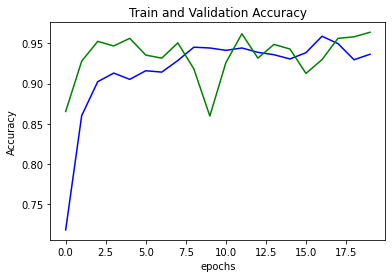

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b',label='Train')
plt.plot(history.history['val_acc'], color='g',label='Test')
plt.title("Train and Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

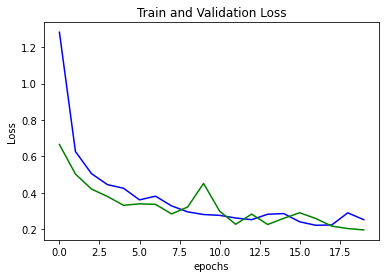

In [ ]:
plt.plot(history.history['loss'], color='b',label='Train')
plt.plot(history.history['val_loss'], color='g',label='Test')
plt.title("Train and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()
# stable at around 0.3

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(mtx, group, title='Confusion Matrix'):
    plt.imshow(mtx, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(group)))
    plt.xticks(xlocations, group)
    plt.yticks(xlocations, group)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    ind_array = np.arange(len(group))
    x,y = np.meshgrid(ind_array, ind_array)
    for i,j in zip(x.flatten(), y.flatten()):
      v = mtx[j][i]
      plt.text(j, i,"%0.2f"%(v,),fontsize=20,ha='center',color='grey')

[[160  11]
 [ 16 399]]


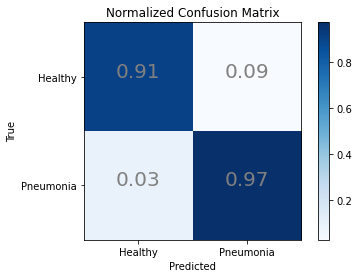

In [ ]:
label=['Healthy','Pneumonia']
y_pred=model.predict(test_gen).round()
conf_mat = confusion_matrix(test_df.y.apply(float).tolist(), y_pred.T.tolist()[0])
print(conf_mat)
plot_confusion_matrix(conf_mat/sum(conf_mat), label,'Normalized Confusion Matrix')

Trying to increase the type I accuracy by improving the data quality.

## Transform Data Quality

In [ ]:
from PIL import ImageStat, Image, ImageEnhance, ImageOps, ImageStat
import math


def brightness_name(i,path): #normal[150]
  im = Image.open(path+'/'+i)
  if im.mode!='RGB':
    im = im.convert("RGB")
  im = im.resize((256,256))
  sumpixel = []
  for i in range(256):
    for j in range(256):
      r, g, b = im.getpixel((i,j))
      if r > 50: #Below are black
        sumpixel.append(r)
  #print(len(sumpixel))
  return sum(sumpixel)/len(sumpixel)

def brightness_image(im): #normal[150]
  if im.mode!='RGB':
    im = im.convert("RGB")
  im = im.resize((256,256))
  sumpixel = []
  for i in range(256):
    for j in range(256):
      r, g, b = im.getpixel((i,j))
      if r > 50: #Below are black
        sumpixel.append(r)
  #print(len(sumpixel))
  return sum(sumpixel)/len(sumpixel)


def switch(i,path,path_new):
  img=Image.open(path+'/'+i).convert("L")
  img_new=img.resize((256,256))
  img_new=ImageOps.autocontrast(img_new)
  img_new=ImageEnhance.Sharpness(img_new).enhance(1.2)
  img_new=ImageOps.colorize(img_new,(0,0,0),(255,255,255),blackpoint=50)
  brightness=brightness_image(img_new)
  #print(brightness)
  img_new=ImageEnhance.Brightness(img_new).enhance(150/brightness)
  img_new.save(path_new+'/'+i)


path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data'
path_new='/content/drive/Shareddrives/Deep Learning/Deep Learning/data2'

for i in df.image:
  switch(i,path,path_new)

# PNEUMONIA/person153_bacteria_726.jpeg
# NORMAL/NORMAL2-IM-0246-0001.jpeg
# PNEUMONIA/person1165_bacteria_3111.jpeg
# PNEUMONIA/person3_virus_17.jpeg
# PNEUMONIA/person1158_virus_1938.jpeg
# PNEUMONIA/person1176_virus_1997.jpeg
# PNEUMONIA/person1644_bacteria_4361.jpeg
# PNEUMONIA/person1590_bacteria_4175.jpeg

## Binary Model with Transormed Data

In [ ]:
path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data2'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
target_size=(256,256)
# Instantiate ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1./255) 
train_gen = train_datagen.flow_from_dataframe(
    train_df,
      directory=path,
      target_size=target_size,
      class_mode='binary',
      color_mode='rgb',
      x_col='image',
      y_col='y',
      batch_size=16,
      shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255) #rescale=1./255
val_gen = val_datagen.flow_from_dataframe(
    val_df,
      directory=path,
      target_size=target_size,
      class_mode='binary',
      color_mode='rgb',
      x_col='image',
      y_col='y',
      shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255) #rescale=1./255
test_gen = test_datagen.flow_from_dataframe(
    test_df,
      directory=path,
      target_size=target_size,
      class_mode='binary',
      color_mode='rgb',
      x_col='image',
      y_col='y',
      shuffle=False)


Found 4743 validated image filenames belonging to 2 classes.
Found 527 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam


# Pile up layers. 
model=Sequential()
model.add(Conv2D(48,3,input_shape=(256,256,3),activation="relu"))
model.add(MaxPooling2D(2))
#model.add(Conv2D(32,3,activation="relu"))
#model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(48,activation="relu",kernel_regularizer="l2"))
#model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

# Compile model
model.compile(loss="binary_crossentropy",
      optimizer=Adam(learning_rate=5e-5),
      metrics=['acc'])

# Fit model. 
history=model.fit(train_gen,
      batch_size=16,                             
      epochs=20, 
      steps_per_epoch=64,               
      validation_data=val_gen                             
      )
print(model.evaluate(test_gen))
model.summary()

Epoch 1/20
64/64 [==============================] - 184s 3s/step - loss: 1.3731 - acc: 0.7347 - val_loss: 0.6728 - val_acc: 0.8899
Epoch 2/20
64/64 [==============================] - 138s 2s/step - loss: 0.6175 - acc: 0.8794 - val_loss: 0.4709 - val_acc: 0.9241
Epoch 3/20
64/64 [==============================] - 108s 2s/step - loss: 0.4694 - acc: 0.9032 - val_loss: 0.4642 - val_acc: 0.9032
Epoch 4/20
64/64 [==============================] - 80s 1s/step - loss: 0.3832 - acc: 0.9371 - val_loss: 0.3800 - val_acc: 0.9146
Epoch 5/20
64/64 [==============================] - 72s 1s/step - loss: 0.3802 - acc: 0.9313 - val_loss: 0.3324 - val_acc: 0.9355
Epoch 6/20
64/64 [==============================] - 70s 1s/step - loss: 0.3040 - acc: 0.9579 - val_loss: 0.3080 - val_acc: 0.9393
Epoch 7/20
64/64 [==============================] - 47s 732ms/step - loss: 0.3119 - acc: 0.9365 - val_loss: 0.2902 - val_acc: 0.9355
Epoch 8/20
64/64 [==============================] - 33s 514ms/step - loss: 0.2891 - 

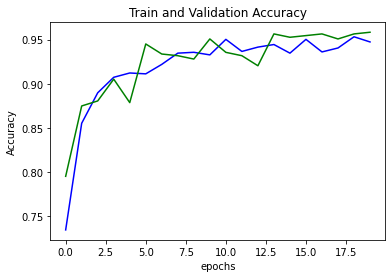

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b',label='Train')
plt.plot(history.history['val_acc'], color='g',label='Test')
plt.title("Train and Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

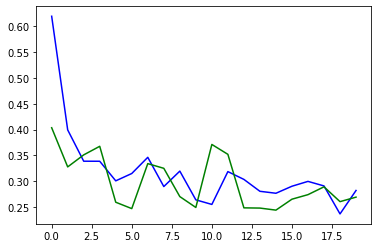

In [ ]:
plt.plot(history.history['loss'], color='b',label='Train')
plt.plot(history.history['val_loss'], color='g',label='Test')
plt.title("Train and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()
# stable at around 0.3

[[147  13]
 [ 13 413]]


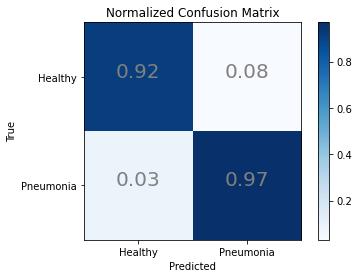

In [ ]:
label=['Healthy','Pneumonia']
y_pred=model.predict(test_gen).round()
conf_mat = confusion_matrix(test_df.y.apply(float).tolist(), y_pred.T.tolist()[0])
print(conf_mat)
plot_confusion_matrix(conf_mat/sum(conf_mat), label,'Normalized Confusion Matrix')

The results of the model is satisfaying, so we save the model for future use.

In [ ]:
model.save('/content/model_pneumonia')

## Categorical Model with Transformed Data

In [ ]:
path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data2'#contrast transformed

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
columns=['normal','bacteria','virus']
target_size=(256,256)
train_datagen_2 = ImageDataGenerator(rescale=1./255) 
train_gen_2 = train_datagen_2.flow_from_dataframe(
    train_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #y_col=columns,
      batch_size=16,
      shuffle=True)

val_datagen_2 = ImageDataGenerator(rescale=1./255) #rescale=1./255
val_gen_2 = val_datagen_2.flow_from_dataframe(
    val_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #columns,
      batch_size=16,
      shuffle=True)

test_datagen_2 = ImageDataGenerator(rescale=1./255) #rescale=1./255
test_gen_2 = test_datagen_2.flow_from_dataframe(
    test_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #columns,
      #batch_size=1,
      shuffle=False)


Found 4743 validated image filenames belonging to 3 classes.
Found 527 validated image filenames belonging to 3 classes.
Found 586 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D,BatchNormalization,SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.metrics as metrics

# Pile up layers. 
model_2=Sequential()
model_2.add(Conv2D(64,3,input_shape=(256,256,3),activation='relu'))
model_2.add(Conv2D(32,3,activation="relu",kernel_regularizer="l2"))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(2))
#model_2.add(SeparableConv2D(128,3,activation="relu"))
#model_2.add(SeparableConv2D(256,3,activation="relu"))
#model_2.add(BatchNormalization())
#model_2.add(MaxPooling2D(2))
#model_2.add(SeparableConv2D(128,3,activation="relu"))
#model_2.add(BatchNormalization())
#model_2.add(MaxPooling2D(2))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(64,activation="relu"))
model_2.add(Dropout(0.4))
# model_2.add(Dense(16,activation="relu")) ##
model_2.add(Dense(3,activation="softmax"))#'sigmoid'#'softmax'

# Compile model
model_2.compile(loss="binary_crossentropy",#"binary_crossentropy"
      optimizer=Adam(learning_rate=5e-6),
      metrics=['acc', metrics.Precision(), metrics.Recall()])

# Fit model. 
#model_2.summary()

# Fit model. 
history_2=model_2.fit(train_gen_2,
      batch_size=16,                               
      epochs=25,
      validation_data=val_gen_2,
      steps_per_epoch=64
     # use_multiprocessing=1,
      )


Epoch 1/25
64/64 [==============================] - 8s 109ms/step - loss: 1.0664 - acc: 0.5186 - precision_14: 0.5444 - recall_14: 0.4689 - val_loss: 1.0592 - val_acc: 0.6433 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00
Epoch 2/25
64/64 [==============================] - 7s 103ms/step - loss: 0.9139 - acc: 0.6686 - precision_14: 0.7087 - recall_14: 0.6181 - val_loss: 1.0479 - val_acc: 0.6110 - val_precision_14: 1.0000 - val_recall_14: 0.0266
Epoch 3/25
64/64 [==============================] - 7s 102ms/step - loss: 0.8753 - acc: 0.6908 - precision_14: 0.7260 - recall_14: 0.6524 - val_loss: 1.0280 - val_acc: 0.6774 - val_precision_14: 0.9714 - val_recall_14: 0.1290
Epoch 4/25
64/64 [==============================] - 7s 104ms/step - loss: 0.8570 - acc: 0.6905 - precision_14: 0.7190 - recall_14: 0.6453 - val_loss: 0.9717 - val_acc: 0.7343 - val_precision_14: 0.9310 - val_recall_14: 0.3586
Epoch 5/25
64/64 [==============================] - 7s 103ms/step - loss: 0.8220 - acc: 

In [ ]:
model_2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 252, 252, 32)      18464     
_________________________________________________________________
batch_normalization_22 (Batc (None, 252, 252, 32)      128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 508032)            0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 508032)            0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)              

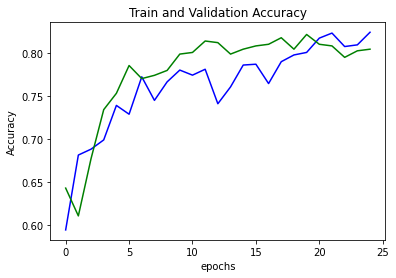

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_2.history['acc'], color='b',label='Train')
plt.plot(history_2.history['val_acc'], color='g',label='Test')
plt.title("Train and Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

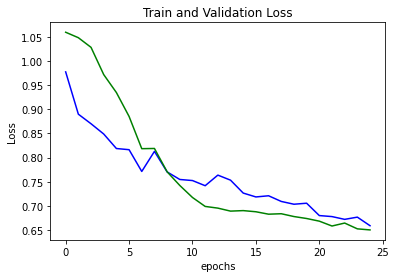

In [ ]:
plt.plot(history_2.history['loss'], color='b',label='Train')
plt.plot(history_2.history['val_loss'], color='g',label='Test')
plt.title("Train and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
model_2.evaluate(test_gen_2)

19/19 [==============================] - 2s 101ms/step - loss: 0.6246 - acc: 0.8055 - precision_10: 0.8065 - recall_10: 0.8038


[0.6245525479316711, 0.8054607510566711, 0.806506872177124, 0.8037542700767517]

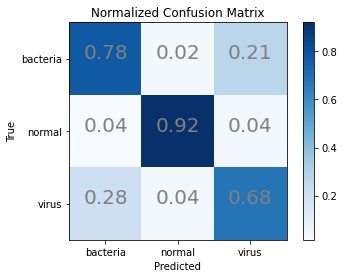

In [ ]:
y_pred_2=model_2.predict(test_gen_2).tolist()
label=['bacteria','normal','virus']
for i in range(len(y_pred_2)):
  max_index = y_pred_2[i].index(max(y_pred_2[i]))
  y_pred_2[i] = label[max_index]

conf_mat_2=confusion_matrix(test_df.y1.tolist(),y_pred_2)
plot_confusion_matrix(conf_mat_2/sum(conf_mat_2), label, 'Normalized Confusion Matrix')

We obtain similar accuracy for predicting normal chest X-ray images and the accuracy of predicting bacterial infection is 70%, but the viral pneumonia type can only be predicted with an accuracy of 68%. After looking back into the distribution of different types in the dataset, we found that viral type has significantly smaller dataset compared with bacterial type. Therefore, we decided to try data augmentation and use stratify sample for the following trials.

## Categorical Model With Stratify Sample

We select stratified sample according to category variable y1.

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df=train_test_split(df,train_size=0.9,stratify=df.y1)
train_df, val_df=train_test_split(train_df,train_size=0.9,stratify=train_df.y1)
print(train_df.shape,val_df.shape,test_df.shape)

(4743, 6) (527, 6) (586, 6)


We define our data augmentation method to be 'rotation' with a rotation range from 0 to 90 degree.

In [ ]:
path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data2'#contrast transformed

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
columns=['normal','bacteria','virus']
target_size=(256,256)
train_datagen_2 = ImageDataGenerator(rotation_range=90,rescale=1./255) 
train_gen_2 = train_datagen_2.flow_from_dataframe(
    train_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #y_col=columns,
      batch_size=16,
      shuffle=True)

val_datagen_2 = ImageDataGenerator(rescale=1./255) #rescale=1./255
val_gen_2 = val_datagen_2.flow_from_dataframe(
    val_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #columns,
      batch_size=16,
      shuffle=True)

test_datagen_2 = ImageDataGenerator(rescale=1./255) #rescale=1./255
test_gen_2 = test_datagen_2.flow_from_dataframe(
    test_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #columns,
      #batch_size=1,
      shuffle=False)


Found 4743 validated image filenames belonging to 3 classes.
Found 527 validated image filenames belonging to 3 classes.
Found 586 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D,BatchNormalization,SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.metrics as metrics

# Pile up layers. 
model_2=Sequential()
model_2.add(Conv2D(128,3,input_shape=(256,256,3),activation='relu'))
model_2.add(Conv2D(64,3,activation="relu"))#,kernel_regularizer="l2"
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(2))
model_2.add(Flatten())
model_2.add(Dropout(0.2))
model_2.add(Dense(128,activation="relu"))
#model_2.add(Dropout(0.2))
model_2.add(Dense(16,activation="relu")) ##
model_2.add(Dense(3,activation="softmax"))#'sigmoid'#'softmax'

# Compile model
model_2.compile(loss="binary_crossentropy",#"binary_crossentropy"
      optimizer=Adam(learning_rate=5e-6),
      metrics=['acc', metrics.Precision(), metrics.Recall()])

# Fit model. 
model_2.summary()

# Fit model. 
history_2=model_2.fit(train_gen_2,
      batch_size=64,                               
      epochs=25,
      validation_data=val_gen_2,
      steps_per_epoch=64)
model_2.evaluate(test_gen_2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      73792     
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1016064)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

[0.3502035439014435,
 0.7576791644096375,
 0.7755835056304932,
 0.7372013926506042]

The model used methods stratified sample and data augmentation does not present a satisfying result, so we would abandon stratified sample and apply data augmentation alone in the following model.

## Categorical Model With Data Augmentation

In [ ]:
path='/content/drive/Shareddrives/Deep Learning/Deep Learning/data2'#contrast transformed

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
columns=['normal','bacteria','virus']
target_size=(256,256)
train_datagen_2 = ImageDataGenerator(rotation_range=90,rescale=1./255) 
train_gen_2 = train_datagen_2.flow_from_dataframe(
    train_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #y_col=columns,
      batch_size=16,
      shuffle=True)

val_datagen_2 = ImageDataGenerator(rescale=1./255) #rescale=1./255
val_gen_2 = val_datagen_2.flow_from_dataframe(
    val_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #columns,
      batch_size=16,
      shuffle=True)

test_datagen_2 = ImageDataGenerator(rescale=1./255) #rescale=1./255
test_gen_2 = test_datagen_2.flow_from_dataframe(
    test_df,
      directory=path,
      target_size=target_size,
      color_mode='rgb',
      class_mode="categorical",
      x_col='image',
      y_col='y1',
      #columns,
      #batch_size=1,
      shuffle=False)


Found 4743 validated image filenames belonging to 3 classes.
Found 527 validated image filenames belonging to 3 classes.
Found 586 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D,BatchNormalization,SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.metrics as metrics

# Pile up layers. 
model_2=Sequential()
model_2.add(Conv2D(128,3,input_shape=(256,256,3),activation='relu'))
model_2.add(Conv2D(64,3,activation="relu"))#,kernel_regularizer="l2"
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(2))
model_2.add(Flatten())
model_2.add(Dropout(0.2))
model_2.add(Dense(128,activation="relu"))
#model_2.add(Dropout(0.2))
model_2.add(Dense(16,activation="relu")) ##
model_2.add(Dense(3,activation="softmax"))#'sigmoid'#'softmax'

# Compile model
model_2.compile(loss="binary_crossentropy",#"binary_crossentropy"
      optimizer=Adam(learning_rate=5e-6),
      metrics=['acc', metrics.Precision(), metrics.Recall()])

# Fit model. 
model_2.summary()

# Fit model. 
history_2=model_2.fit(train_gen_2,
      batch_size=64,                               
      epochs=25,
      validation_data=val_gen_2,
      steps_per_epoch=64)
model_2.evaluate(test_gen_2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 252, 252, 64)      73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1016064)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1016064)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

[0.31410911679267883,
 0.8020477890968323,
 0.809440553188324,
 0.7901023626327515]

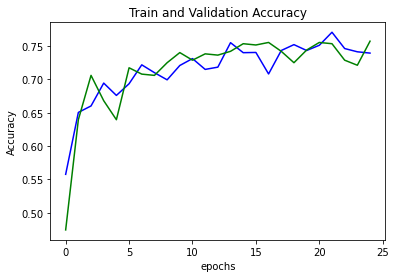

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history_2.history['acc'], color='b',label='Train')
plt.plot(history_2.history['val_acc'], color='g',label='Test')
plt.title("Train and Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

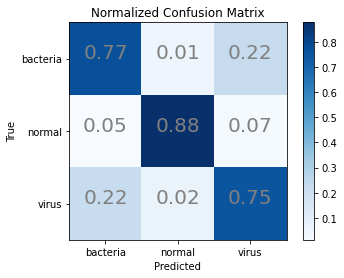

In [ ]:
y_pred_2=model_2.predict(test_gen_2).tolist()
label=['bacteria','normal','virus']
for i in range(len(y_pred_2)):
  max_index = y_pred_2[i].index(max(y_pred_2[i]))
  y_pred_2[i] = label[max_index]

conf_mat_2=confusion_matrix(test_df.y1.tolist(),y_pred_2)
plot_confusion_matrix(conf_mat_2/sum(conf_mat_2), label, 'Normalized Confusion Matrix')

Although the overall test accuracy of the model is almost the same as the initial categorical model we built, the accuracy of predicting viral infection increases from 68% to 75%, which is what we expected for the adjustment.